# Content based Recommender System in Pyspark
####  By Prajakta Chaudhari
####  Duration: 28 days

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F
from pyspark.sql.functions import log
from nltk.corpus import stopwords
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import IDF
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from pyspark.ml.linalg import *
from pyspark.ml.feature import IndexToString, StringIndexer

In [2]:
spark = SparkSession.builder.appName('rec').getOrCreate()

Reading users_interactions data

In [3]:
interactions_df = spark.read.csv('users_interactions.csv',header=True, inferSchema=True)
interactions_df
#interactions_df.head(10)

DataFrame[timestamp: int, eventType: string, contentId: bigint, personId: bigint, sessionId: bigint, userAgent: string, userRegion: string, userCountry: string]

In [4]:
indexer = StringIndexer(inputCol="eventType", outputCol="eventStrength")
indexed = indexer.fit(interactions_df).transform(interactions_df) 
indexed1 = indexed.withColumn('eventStrength1',indexed['eventStrength']+1)
indexed1.select(['eventType','eventStrength']).distinct().show()

+---------------+-------------+
|      eventType|eventStrength|
+---------------+-------------+
|       BOOKMARK|          2.0|
|COMMENT CREATED|          3.0|
|           LIKE|          1.0|
|         FOLLOW|          4.0|
|           VIEW|          0.0|
+---------------+-------------+



In [5]:
indexed1 = indexed1.withColumn('eventStrength1',
    F.when(indexed1['eventStrength']==2,2.5).
    otherwise(indexed1['eventStrength']))
indexed1 = indexed1.withColumn('eventStrength2',
    F.when(indexed1['eventStrength1']==1,2).
    otherwise(indexed1['eventStrength1']))
indexed1 = indexed1.withColumn('eventStrength3',
    F.when(indexed1['eventStrength2']==0,1).
    otherwise(indexed1['eventStrength2']))
indexed1 = indexed1.withColumn('eventStrength4',
    F.when(indexed1['eventStrength3']==4,3.5).
    otherwise(indexed1['eventStrength3']))
indexed1 = indexed1.withColumn('eventStrength5',
    F.when(indexed1['eventStrength4']==3,4).
    otherwise(indexed1['eventStrength4']))
indexed1 = indexed1.withColumn('eventStrength6',
    F.when(indexed1['eventStrength5']==3.5,3).
    otherwise(indexed1['eventStrength5']))
indexed1.select(['eventType','eventStrength6']).distinct().show()

+---------------+--------------+
|      eventType|eventStrength6|
+---------------+--------------+
|COMMENT CREATED|           4.0|
|       BOOKMARK|           2.5|
|           VIEW|           1.0|
|         FOLLOW|           3.0|
|           LIKE|           2.0|
+---------------+--------------+



In [6]:
temp = indexed1.select(['personId','contentId','eventStrength6']).groupby(['personId','contentId']).sum()
temp = temp.select(['personId','contentId','sum(eventStrength6)'])
temp = temp.withColumnRenamed('sum(eventStrength6)','eventStrength')
temp = temp.withColumn("eventStrength1", temp.eventStrength+1)
temp = temp.select(['personId','contentId','eventStrength1'])
temp = temp.withColumn("eventStrength", log("eventStrength1"))
import math
from pyspark.sql.functions import concat, col, lit
CONSTANT = math.log(2)
temp=temp.withColumn("eventStrength2", col('eventStrength')/CONSTANT)
temp = temp.select(['personId','contentId','eventStrength2'])
temp=temp.withColumnRenamed("eventStrength2","eventStrength")
interactions_full_df = temp.select(['personId','contentId','eventStrength'])
interactions_full_df.sort("personId", ascending=True).show()

+--------------------+--------------------+------------------+
|            personId|           contentId|     eventStrength|
+--------------------+--------------------+------------------+
|-9223121837663643404| 3180828616327439381|               1.0|
|-9223121837663643404| 4563606877148407012|               1.0|
|-9223121837663643404|-8187220755213888616|               1.0|
|-9223121837663643404|-8208801367848627943|               1.0|
|-9223121837663643404|-5781461435447152359|               1.0|
|-9223121837663643404|-8377626164558006982|               1.0|
|-9223121837663643404| 5293701842202310496|               1.0|
|-9223121837663643404| 7734121175534200554|               1.0|
|-9223121837663643404|-2402288292108892893|1.5849625007211563|
|-9223121837663643404|-6484638837208285334|               1.0|
|-9223121837663643404| 5211673327552264703|               1.0|
|-9223121837663643404| 7229629480273331039|               1.0|
|-9223121837663643404| 8310689940464940949|            

Reading shared_articles data

In [7]:
articles_df = spark.read.csv('shared_articles.csv',inferSchema=True,header=True)
#For the sake of simplicity, we only consider here the "CONTENT SHARED" event type
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
#articles_df.head(5)

In [ ]:
#choose only english language articles
#articles_df = articles_df[articles_df['lang'] == 'en']

In [8]:
interactions_indexed_df = interactions_full_df.join(articles_df,['contentId'])
interactions_indexed_df = interactions_indexed_df.select(['personId','contentId','eventStrength'])

In [9]:
distinct_personIds = interactions_indexed_df.select('personId').distinct()
distinct_personIds = distinct_personIds.select('personId').collect()

Concatnating Title and text columns

In [10]:
from pyspark.sql.functions import concat, col, lit
articles_df = articles_df.withColumn('TitleNText',concat(col("title"), lit(" "), col("text")))
articles_df = articles_df.select(['contentId','TitleNText'])
articles_df.count()
articles_df = articles_df.na.drop(subset=["TitleNText"])
articles_df.count()

3046

In [11]:
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="TitleNText", outputCol="words", pattern="\\W")
wordsData = regexTokenizer.transform(articles_df)

In [12]:
# remove stop words
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stopwords_list)
stopwordsRemoved = stopwordsRemover.transform(wordsData)
del(wordsData)

In [13]:
stopwordsRemoved.select('filtered').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=5000)
countVectors = countVectors.fit(stopwordsRemoved)
countVectored=countVectors.transform(stopwordsRemoved)
del(stopwordsRemoved)

In [15]:
countVectored.select('features').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
#Creating TF-IDF matrix
idf = IDF(inputCol="features", outputCol="Finalfeatures")
idfModel = idf.fit(countVectored)
tfidf_matrix = idfModel.transform(countVectored)
del(countVectored)

In [17]:
tfidf_matrix.select("Finalfeatures").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
def get_item_profile(item_id):
    temp= item_id
    item_profile = tfidf_matrix.filter(tfidf_matrix.contentId.isin(temp[0]))
    return item_profile

In [19]:
def get_item_profiles(ids):
    x = ids.collect()[0]
    item_profiles_list = get_item_profile(x)
    for i in range(ids.count()):
        if i>0:
            #print(i)
            temp = get_item_profile(ids.collect()[i])
            item_profiles_list = item_profiles_list.union(temp)
    return item_profiles_list

In [20]:
import numpy as np
import sklearn
def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.filter(interactions_indexed_df.personId.isin(person_id[0]))
    user_item_profiles = get_item_profiles(interactions_person_df.select('contentId'))
    #user_item_profiles = user_item_profiles.select('Finalfeatures')
    user_item_strengths = interactions_person_df.select('eventStrength')
    newDf = interactions_person_df.join(user_item_profiles,interactions_person_df.contentId==user_item_profiles.contentId)
    user_item_profiles = newDf.select('Finalfeatures')
    nrowss = user_item_profiles.count()
    sparsemat = np.zeros((nrowss,5000))
    for i in range(nrowss):
        #print(i)
        sparsemat[i,((user_item_profiles.collect()[i][0]).indices)] = (user_item_profiles.collect()[i][0]).values
    strengths = np.array((user_item_strengths.toPandas()).iloc[:,0])
    sparsemat_mul_Strengths=((sparsemat * strengths[:, np.newaxis]))
    user_item_strengths_weighted_avg = np.sum(sparsemat_mul_Strengths,axis=0)/np.sum(strengths)
#    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg.reshape(-1,1))
    return user_item_strengths_weighted_avg

In [21]:
person_id = distinct_personIds[0]
personId = distinct_personIds[0][0]
interactions_person_df = interactions_indexed_df.filter(interactions_indexed_df.personId.isin(personId))
interactions_person_df.show()

+-------------------+--------------------+------------------+
|           personId|           contentId|     eventStrength|
+-------------------+--------------------+------------------+
|3568240335801676264|-2948321821574578861|1.5849625007211563|
|3568240335801676264|-8717945432162716060|               2.0|
|3568240335801676264|-5571606607344218289|1.5849625007211563|
|3568240335801676264| 3472032465864014134|               1.0|
|3568240335801676264|-5736221996280340620|               1.0|
|3568240335801676264| 5338677278233757627|               1.0|
|3568240335801676264| 1356221992133852808|1.5849625007211563|
|3568240335801676264|-3678789633202302491|               1.0|
|3568240335801676264|-5605799891597699962|               1.0|
|3568240335801676264| 8522523292310933696|               2.0|
|3568240335801676264|-6058152698516590252|               1.0|
|3568240335801676264|-6623581327558800021|               1.0|
|3568240335801676264| 2715453133655798791|               1.0|
|3568240

In [22]:
# write function to calculate cosine similarity
def cos_sim(a,b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

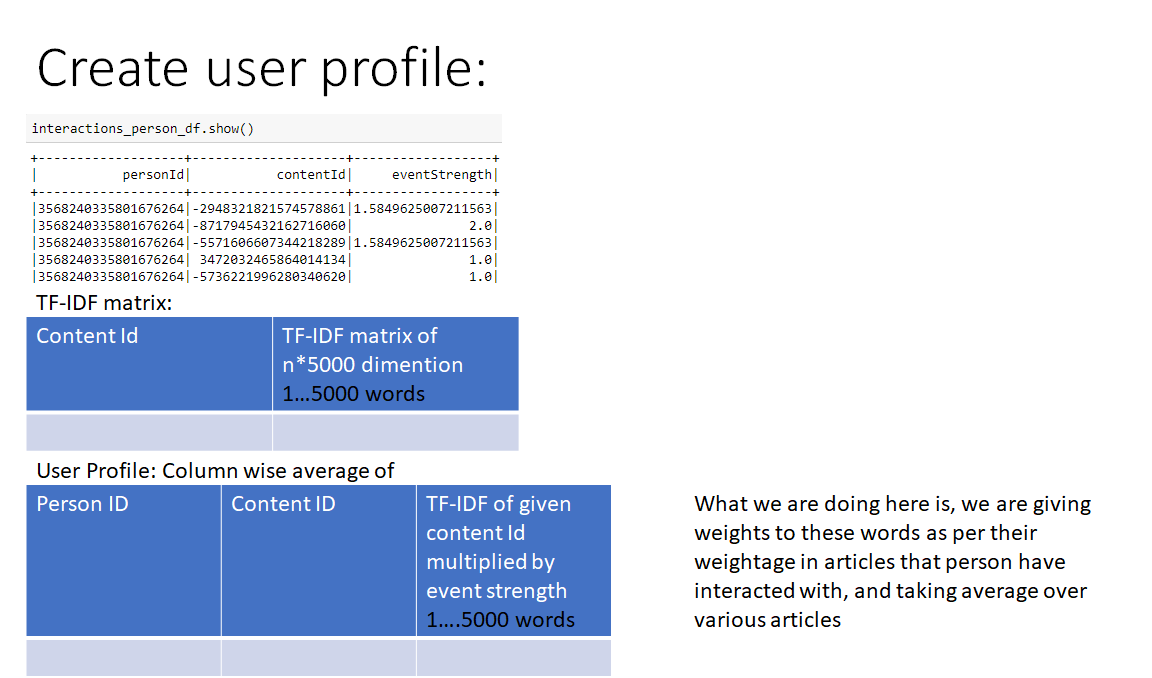

In [23]:
user_item_strengths_weighted_avg = build_users_profile(person_id, interactions_indexed_df)

The method of calculating the user’s likes / dislikes / measures is calculated by taking the cosine of the angle between the user profile vector and the document vector.

In [28]:
interactions_person_df = interactions_indexed_df.filter(interactions_indexed_df.personId.isin(person_id[0]))
df = tfidf_matrix.withColumn("coSim", udf(cos_sim, FloatType())(col("Finalfeatures"), array([lit(v) for v in user_item_strengths_weighted_avg])))
#df = df.select(['contentId','coSim'])
df1 = df.sort("coSim", ascending=False)
items_to_ignore=interactions_person_df.select('contentId').collect()
for i in range(len(items_to_ignore)):
    df = df1.filter(~df1.contentId.isin(items_to_ignore[i][0]))
    df2 = df1.filter(df1.contentId.isin(items_to_ignore[i][0]))
#print(df.head(10))
dfpandas = df.toPandas()
dfpandas = dfpandas.iloc[range(10),:]
x = np.array([str(person_id[0])])
x = np.repeat(x, 10, axis=0)
df3 = pd.DataFrame(x, columns = ['Person_id'])
dftemp = pd.concat([df3,dfpandas], axis=1, ignore_index=True)
dftemp

,0,1,2,3,4,5,6,7
0,2944202749145946530,-4278025512576376201,"#Sentaquelávemtextão """"""Me cansei de lero-lero...","[sentaquel, vemtext, o, me, cansei, de, lero, ...","[sentaquel, vemtext, cansei, lero, lero, rita,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
1,2944202749145946530,-3780822597455574960,Top Programming Languages Trends: The Rise of ...,"[top, programming, languages, trends, the, ris...","[top, programming, languages, trends, rise, bi...","(1.0, 1.0, 14.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0,...","(1.5116544384625596, 1.1051977586321, 22.58737...",0.660203
2,2944202749145946530,-3248233692182971167,Debugging WordPress: 11 Powerful Tips and Tech...,"[debugging, wordpress, 11, powerful, tips, and...","[debugging, wordpress, 11, powerful, tips, tec...","(1.0, 3.0, 0.0, 1.0, 0.0, 3.0, 1.0, 0.0, 6.0, ...","(1.5116544384625596, 3.3155932758963003, 0.0, ...",0.608305
3,2944202749145946530,-9083294960368598209,Drupal How-To: Responsive or Adaptive Images? ...,"[drupal, how, to, responsive, or, adaptive, im...","[drupal, responsive, adaptive, images, acquia,...","(0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, ...","(0.0, 1.1051977586321, 0.0, 1.185653501708642,...",0.311184
4,2944202749145946530,8028897172674067530,"20 Awesome PHP Libraries For Summer 2016 ""20 A...","[20, awesome, php, libraries, for, summer, 201...","[20, awesome, php, libraries, summer, 2016, 20...","(1.0, 1.0, 1.0, 5.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","(1.5116544384625596, 1.1051977586321, 1.613383...",0.304525
5,2944202749145946530,787067277772219433,Setting up Drupal Code Sniffer A few weeks ago...,"[setting, up, drupal, code, sniffer, a, few, w...","[setting, drupal, code, sniffer, weeks, ago, g...","(0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 5.0, 0.0, 0.0, ...","(0.0, 1.1051977586321, 0.0, 1.185653501708642,...",0.253605
6,2944202749145946530,-958925381525830552,Monitor your application errors with Stackdriv...,"[monitor, your, application, errors, with, sta...","[monitor, application, errors, stackdriver, er...","(0.0, 4.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...","(0.0, 4.4207910345284, 0.0, 0.0, 0.0, 2.725237...",0.249709
7,2944202749145946530,6565723369088595990,Learn About the PHP Trends and Predictions for...,"[learn, about, the, php, trends, and, predicti...","[learn, php, trends, predictions, 2017, php, c...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 1.1051977586321, 0.0, 0.0, 0.0, 0.0, 0.0...",0.225216
8,2944202749145946530,-1242702988593021334,"PHP 7 Support in PhpStorm 2016.2 ""PHP 7 is gai...","[php, 7, support, in, phpstorm, 2016, 2, php, ...","[php, 7, support, phpstorm, 2016, 2, php, 7, g...","(0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.185653501708642, 0.0, 1.3626...",0.214047
9,2944202749145946530,8049667463017473012,Miracles of Human Language: An Introduction to...,"[miracles, of, human, language, an, introducti...","[miracles, human, language, introduction, ling...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.3626188593020716, ...",0.213101


In [29]:
dfpandas2 = df2.toPandas()
dfpandas2 = dfpandas2.iloc[range(10),:]
x = np.array([str(person_id[0])])
x = np.repeat(x, 10, axis=0)
df3 = pd.DataFrame(x, columns = ['Person_id'])
dftemp = pd.concat([df3,dfpandas2], axis=1, ignore_index=True)
dftemp

IndexError: positional indexers are out-of-bounds

In [27]:
#For all person Ids
tfidf_matrix1 = tfidf_matrix.select(['contentId', 'Finalfeatures'])
recommendations_df = pd.DataFrame()
for person_id in distinct_personIds:
    print(person_id)
    user_item_strengths_weighted_avg = build_users_profile(person_id, interactions_indexed_df)
    interactions_person_df = interactions_indexed_df.filter(interactions_indexed_df.personId.isin(person_id[0]))
    df = tfidf_matrix.withColumn("coSim", udf(cos_sim, FloatType())(col("Finalfeatures"), array([lit(v) for v in user_item_strengths_weighted_avg])))
    #df = df.select(['contentId','coSim'])
    df = df.sort("coSim", ascending=False)
    items_to_ignore=interactions_person_df.select('contentId').collect()
    for i in range(len(items_to_ignore)):
        df = df.filter(~df.contentId.isin(items_to_ignore[i][0]))
    #print(df.head(10))
    dfpandas = df.toPandas()
    dfpandas = dfpandas.iloc[range(10),:]
    x = np.array([str(person_id[0])])
    x = np.repeat(x, 10, axis=0)
    df1 = pd.DataFrame(x, columns = ['Person_id'])
    dftemp = pd.concat([df1,dfpandas], axis=1, ignore_index=True)
    recommendations_df = pd.concat([recommendations_df,dftemp],axis = 0,ignore_index=True)
    print(recommendations_df.shape)
    
    

Row(personId=3568240335801676264)
(10, 8)
Row(personId=627408625947732191)
(20, 8)
Row(personId=-3595444231792050977)
(30, 8)
Row(personId=1163668879480930452)
(40, 8)
Row(personId=6465469928207780773)
(50, 8)
Row(personId=-8486803825457737124)
(60, 8)
Row(personId=5331529367419076871)
(70, 8)
Row(personId=816623031097334102)
(80, 8)
Row(personId=-7710611945490357590)
(90, 8)
Row(personId=2758633233367218711)
(100, 8)
Row(personId=5469217996124449648)
(110, 8)
Row(personId=2944202749145946530)


KeyboardInterrupt: 

In [ ]:
person_id = distinct_personIds[0]
interactions_person_df = interactions_indexed_df.filter(interactions_indexed_df.personId.isin(person_id[0]))

In [ ]:
interactions_person_df.select('contentId')

In [ ]:
articles_df = spark.read.csv('shared_articles.csv',inferSchema=True,header=True)
#For the sake of simplicity, we only consider here the "CONTENT SHARED" event type
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']

In [ ]:
newDFF = interactions_person_df.join(articles_df,interactions_person_df.contentId==articles_df.contentId)

In [ ]:
newDFF.select(['Title','Text']).show(truncate=False)

In [ ]:
recommendations_df.iloc[0,2]

In [ ]:
recommendations_df.iloc[1,2]

In [ ]:
recommendations_df.iloc[2,2]

In [ ]:
recommendations_df.iloc[3,2]

In [ ]:
tfidf_matrix1 = tfidf_matrix.select(['contentId', 'Finalfeatures'])
user_item_strengths_weighted_avg = build_users_profile(person_id, interactions_indexed_df)
interactions_person_df = interactions_indexed_df.filter(interactions_indexed_df.personId.isin(person_id[0]))
df = tfidf_matrix1.withColumn("coSim", udf(cos_sim, FloatType())(col("Finalfeatures"), array([lit(v) for v in user_item_strengths_weighted_avg])))
df = df.select(['contentId','coSim'])
df = df.sort("coSim", ascending=False)
items_to_ignore=interactions_person_df.select('contentId').collect()
for i in range(len(items_to_ignore)):
    df = df.filter(~df.contentId.isin(items_to_ignore[i][0]))
dfpandas = df.toPandas()

dfpandas = dfpandas.iloc[range(10),:]

In [ ]:
dfpandas = dfpandas.iloc[range(10),:]

In [ ]:
x = np.array([str(person_id[0])])
x = np.repeat(x, 10, axis=0)
df1 = pd.DataFrame(x, columns = ['Person_id'])

In [ ]:
#person_id[0]
dftemp = pd.concat([df1,dfpandas], axis=1, ignore_index=True)
dftemp

In [ ]:
#user_item_strengths_weighted_avg = build_users_profile(person_id, interactions_indexed_df)
interactions_person_df = interactions_indexed_df.filter(interactions_indexed_df.personId.isin(person_id[0]))
df = tfidf_matrix.withColumn("coSim", udf(cos_sim, FloatType())(col("Finalfeatures"), array([lit(v) for v in user_item_strengths_weighted_avg])))
#df = df.select(['contentId','coSim'])
df = df.sort("coSim", ascending=False)
items_to_ignore=interactions_person_df.select('contentId').collect()
for i in range(len(items_to_ignore)):
    df = df.filter(~df.contentId.isin(items_to_ignore[i][0]))
dfpandas = df.toPandas()

dfpandas = dfpandas.iloc[range(10),:]

In [ ]:
dfpandas = dfpandas.iloc[range(10),:]
x = np.array([str(person_id[0])])
x = np.repeat(x, 10, axis=0)
df1 = pd.DataFrame(x, columns = ['Person_id'])
dftemp = pd.concat([df1,dfpandas], axis=1, ignore_index=True)
dftemp